In [ ]:
import os
import shutil

os.makedirs("/root/.kaggle", exist_ok=True)
!mv /content/kaggle.json /root/.kaggle/

!chmod 600 /root/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

Dataset URL: https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
License(s): CC0-1.0


In [ ]:
!unzip /content/gtsrb-german-traffic-sign.zip -d /content/GTSRB_Data

Streaming output truncated to the last 5000 lines.
  inflating: /content/GTSRB_Data/train/5/00005_00053_00010.png  
  inflating: /content/GTSRB_Data/train/5/00005_00053_00011.png  
  inflating: /content/GTSRB_Data/train/5/00005_00053_00012.png  
  inflating: /content/GTSRB_Data/train/5/00005_00053_00013.png  
  inflating: /content/GTSRB_Data/train/5/00005_00053_00014.png  
  inflating: /content/GTSRB_Data/train/5/00005_00053_00015.png  
  inflating: /content/GTSRB_Data/train/5/00005_00053_00016.png  
  inflating: /content/GTSRB_Data/train/5/00005_00053_00017.png  
  inflating: /content/GTSRB_Data/train/5/00005_00053_00018.png  
  inflating: /content/GTSRB_Data/train/5/00005_00053_00019.png  
  inflating: /content/GTSRB_Data/train/5/00005_00053_00020.png  
  inflating: /content/GTSRB_Data/train/5/00005_00053_00021.png  
  inflating: /content/GTSRB_Data/train/5/00005_00053_00022.png  
  inflating: /content/GTSRB_Data/train/5/00005_00053_00023.png  
  inflating: /content/GTSRB_Data/train/

In [ ]:
import os

# List the files inside the extracted dataset folder
print(os.listdir("/content/GTSRB_Data"))

['Meta.csv', 'Train.csv', 'meta', 'train', 'test', 'Test', 'Train', 'Meta', 'Test.csv']


- <b>Train</b>/ → Contains traffic sign images categorized into subfolders (each folder represents a class).

- <b>Test</b>/ → Contains test images.

- <b>Meta/classes.csv</b> → Contains label mappings.

['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '5', '6', '7', '8', '9']


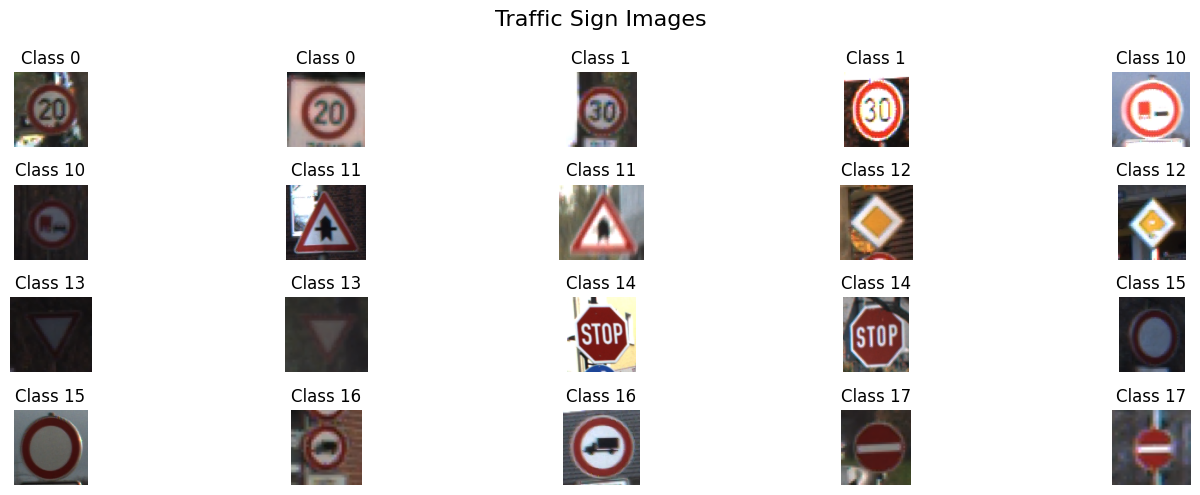

In [ ]:
import cv2
import matplotlib.pyplot as plt
import os


dataset_path = "/content/GTSRB_Data/Train/"


class_folders = sorted(os.listdir(dataset_path))
print(class_folders)

# Initialize an empty list to store image file paths
image_files = []

# Loop through the first few class folders and get image paths
for class_folder in class_folders[:10]:
    class_path = os.path.join(dataset_path, class_folder) # -------------
                                                                        #|
    if os.path.isdir(class_path):                                       #| - Here path join ka mtlb -> getting the
        for img_file in os.listdir(class_path)[:2]:                     #|   information about the whole path and
            image_files.append(os.path.join(class_path, img_file)) # ----    structuring it taki baad me sahi chale.


#print(image_files)
if len(image_files) == 0:
    print(f"No images found in {dataset_path}!")
else:
    num_images = len(image_files)
    num_cols = 5
    num_rows = (num_images + num_cols - 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5))
    fig.suptitle("Traffic Sign Images", fontsize=16)

    axes = axes.flatten() if num_rows > 1 else [axes]

    for i, img_path in enumerate(image_files):
        img = cv2.imread(img_path)

        if img is None:
            print(f"Error loading image: {img_path}")
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        axes[i].imshow(img)
        axes[i].axis("off")
        axes[i].set_title(f"Class {os.path.basename(os.path.dirname(img_path))}")
    for j in range(i+1, len(axes)):
        fig.axes("off")
    plt.tight_layout()
    plt.show()



In [ ]:
import pandas as pd
import numpy as np
import cv2
import os
from tqdm import tqdm

# Define Paths
train_dir = "/content/GTSRB_Data/Train"
test_dir = "//content/GTSRB_Data/Test"
train_csv_path = "/content/GTSRB_Data/Train.csv"
test_csv_path = "/content/GTSRB_Data/Test.csv"

# Function to Load Bounding Boxes from CSV
def load_bbox_data(csv_path):
    df = pd.read_csv(csv_path)
    bbox_dict = {}

    for _, row in df.iterrows():
        filename = os.path.basename(row["Path"])  # Extract filename
        class_id = int(row["ClassId"])
        x_min, y_min, x_max, y_max = row["Roi.X1"], row["Roi.Y1"], row["Roi.X2"], row["Roi.Y2"]

        # Normalize bounding box for YOLO format
        img_width, img_height = row["Width"], row["Height"]
        x_center = ((x_min + x_max) / 2) / img_width
        y_center = ((y_min + y_max) / 2) / img_height
        width = (x_max - x_min) / img_width
        height = (y_max - y_min) / img_height

        # Store in dictionary
        bbox_dict[filename] = [class_id, x_center, y_center, width, height]

    print(f"Loaded {len(bbox_dict)} bounding boxes from {csv_path}")
    return bbox_dict

# Load Bounding Box Data
train_bbox_dict = load_bbox_data(train_csv_path)
test_bbox_dict = load_bbox_data(test_csv_path)


Loaded 39209 bounding boxes from /content/GTSRB_Data/Train.csv
Loaded 12630 bounding boxes from /content/GTSRB_Data/Test.csv


In [ ]:
# Function to Load Images & Assign Bounding Boxes
def load_images_and_labels(image_dir, bbox_dict):
    images, labels = [], []

    for class_folder in sorted(os.listdir(image_dir)):  # Iterate over class folders
        class_path = os.path.join(image_dir, class_folder)

        if os.path.isdir(class_path):
            for img_file in tqdm(os.listdir(class_path), desc=f"Processing {class_folder}"):
                img_path = os.path.join(class_path, img_file)

                # Read & Preprocess Image
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
                img = cv2.resize(img, (64, 64))  # Resize to 64x64
                img = img / 255.0  # Normalize

                images.append(img)

                # Get bounding box
                if img_file in bbox_dict:
                    labels.append(bbox_dict[img_file])
                else:
                    print(f"⚠ Warning: No bbox found for {img_file}, assigning default bbox.")
                    labels.append([0, 0.5, 0.5, 0.5, 0.5])  # Default bbox if missing

    return np.array(images, dtype=np.float32), np.array(labels, dtype=np.float32)

# Load Train & Test Data
X_train, y_train = load_images_and_labels(train_dir, train_bbox_dict)
X_test, y_test = load_images_and_labels(test_dir, test_bbox_dict)


Processing 9: 100%|██████████| 1470/1470 [00:00<00:00, 2576.29it/s]


In [ ]:
from sklearn.model_selection import train_test_split

# Split Training Data (80% Train, 20% Validation)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print(f"Train Set: {X_train.shape[0]} images, Validation Set: {X_val.shape[0]} images")


Train Set: 31367 images, Validation Set: 7842 images


In [ ]:
np.save("/content/Checkpt_1/X_train.npy", X_train)
np.save("/content/Checkpt_1/y_train.npy", y_train)
np.save("/content/Checkpt_1/X_val.npy", X_val)
np.save("/content/Checkpt_1/y_val.npy", y_val)
np.save("/content/Checkpt_1/X_test.npy", X_test)
np.save("/content/Checkpt_1/y_test.npy", y_test)

print("Processed datasets saved successfully!")


Processed datasets saved successfully!


In [ ]:
import albumentations as A
import os

In [ ]:
# Define Augmentation Pipeline
augmentations = A.Compose([
    A.Resize(64, 64, always_apply=True),
    A.Rotate(limit=30, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.MotionBlur(blur_limit=3, p=0.2),
    A.HorizontalFlip(p=0.5),
    A.RandomScale(scale_limit=0.2, p=0.5),
])

<ipython-input-11-2ea30c3e4071>:3: UserWarning: Argument(s) 'always_apply' are not valid for transform Resize
  A.Resize(64, 64, always_apply=True),


In [ ]:
# Function to Apply Augmentations
def augment_and_save(images, labels, save_dir, prefix="aug_"):
    os.makedirs(save_dir, exist_ok=True)
    augmented_images, augmented_labels = [], []

    for i in tqdm(range(len(images)), desc="Augmenting Images"):
        img = images[i]
        label = labels[i]

        # Convert grayscale images to RGB
        img = (img * 255).astype(np.uint8)
        if len(img.shape) == 2:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

        # Apply Augmentations
        augmented = augmentations(image=img)
        aug_img = augmented["image"]

        # Resize Image
        aug_img = cv2.resize(aug_img, (64, 64))

        # Save Augmented Image
        img_path = os.path.join(save_dir, f"{prefix}{i}.jpg")
        cv2.imwrite(img_path, aug_img)

        augmented_images.append(aug_img / 255.0)  # Normalize
        augmented_labels.append(label)

    return np.array(augmented_images, dtype=np.float32), np.array(augmented_labels, dtype=np.float32)


In [ ]:
aug_save_dir = "/content/Augmented_Train"
X_train_aug, y_train_aug = augment_and_save(X_train, y_train, save_dir=aug_save_dir)

Augmenting Images: 100%|██████████| 31367/31367 [00:26<00:00, 1197.17it/s]


In [ ]:
np.save("/content/Checkpt_2/X_train_aug.npy", X_train_aug)
np.save("/content/Checkpt_2/y_train_aug.npy", y_train_aug)

print("Augmented dataset saved successfully!")


Augmented dataset saved successfully!


Bringing in the Data and Converting it to YOLO format

In [ ]:
import os
import numpy as np

# Paths for saving YOLO labels
yolo_labels_dir = "/content/YOLO_Labels"
os.makedirs(yolo_labels_dir, exist_ok=True)

# Function to Convert Labels to YOLO Format
def convert_to_yolo(labels, save_dir, prefix="train_"):
    for i, label in enumerate(labels):
        class_id, x_center, y_center, width, height = label
        label_file = os.path.join(save_dir, f"{prefix}{i}.txt")

        with open(label_file, "w") as f:
            f.write(f"{int(class_id)} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

# Convert Train & Augmented Train Labels
convert_to_yolo(y_train, yolo_labels_dir, prefix="train_")
convert_to_yolo(y_train_aug, yolo_labels_dir, prefix="aug_train_")

print(f"Converted {len(y_train) + len(y_train_aug)} labels to YOLO format!")


Converted 62734 labels to YOLO format!


In [ ]:
import os
import numpy as np

# Paths for saving YOLO labels
yolo_labels_dir = "/content/YOLO_Labels"
os.makedirs(yolo_labels_dir, exist_ok=True)

# Function to Convert Labels to YOLO Format & Save as `.npy`
def convert_and_save_yolo(labels, save_dir, npy_path, prefix="train_"):
    yolo_labels = []

    for i, label in enumerate(labels):
        class_id, x_center, y_center, width, height = label
        yolo_labels.append([class_id, x_center, y_center, width, height])

        # Save as .txt (for YOLO training)
        label_file = os.path.join(save_dir, f"{prefix}{i}.txt")
        with open(label_file, "w") as f:
            f.write(f"{int(class_id)} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

    # Save as .npy file for future use
    np.save(npy_path, np.array(yolo_labels, dtype=np.float32))

# Convert & Save Train Labels
convert_and_save_yolo(y_train, yolo_labels_dir, "/content/Checkpt_3/y_train_yolo.npy", prefix="train_")

# Convert & Save Augmented Train Labels
convert_and_save_yolo(y_train_aug, yolo_labels_dir, "/content/Checkpt_3/y_train_aug_yolo.npy", prefix="aug_train_")

print(f"Saved {len(y_train) + len(y_train_aug)} YOLO labels in .npy format for safety!")


Saved 62734 YOLO labels in .npy format for safety!


In [ ]:
dataset_yaml = """
path: /content
train: YOLO_Labels  # Folder containing training labels
val: YOLO_Labels  # Using the same for validation
nc: 43  # Number of traffic sign classes
names: ['Speed Limit 20', 'Speed Limit 30', 'Speed Limit 50', 'Speed Limit 60',
        'Speed Limit 70', 'Speed Limit 80', 'End of Speed Limit 80', 'Speed Limit 100',
        'Speed Limit 120', 'No Overtaking', 'No Overtaking Trucks', 'Right of Way Intersection',
        'Priority Road', 'Yield', 'Stop', 'No Vehicles', 'No Trucks', 'No Entry',
        'Caution', 'Dangerous Left Curve', 'Dangerous Right Curve', 'Double Curve',
        'Bumpy Road', 'Slippery Road', 'Road Narrows on Right', 'Road Work',
        'Traffic Signals', 'Pedestrian Crossing', 'Children Crossing', 'Bicycles Crossing',
        'Snow Warning', 'Deer Warning', 'End of Speed & Overtaking Limits', 'Turn Right',
        'Turn Left', 'Ahead Only', 'Go Right or Straight', 'Go Left or Straight',
        'Keep Right', 'Keep Left', 'Roundabout Mandatory', 'End of No Passing',
        'End of No Passing for Trucks']
"""

# Save dataset.yaml
with open("/content/dataset.yaml", "w") as f:
    f.write(dataset_yaml)

print("dataset.yaml file created!")


dataset.yaml file created!


In [ ]:
import numpy as np

# Reload Training Data
X_train = np.load("/content/Checkpt_1/X_train.npy")
y_train = np.load("/content/Checkpt_1/y_train.npy")

# Reload Validation Data
X_val = np.load("/content/Checkpt_1/X_val.npy")
y_val = np.load("/content/Checkpt_1/y_val.npy")

# Reload Test Data
X_test = np.load("/content/Checkpt_1/X_test.npy")
y_test = np.load("/content/Checkpt_1/y_test.npy")

# Reload Augmented Training Data
X_train_aug = np.load("/content/Checkpt_2/X_train_aug.npy")
y_train_aug = np.load("/content/Checkpt_2/y_train_aug.npy")

# Reload YOLO-Formatted Labels
y_train_yolo = np.load("/content/Checkpt_3/y_train_yolo.npy")
y_train_aug_yolo = np.load("/content/Checkpt_3/y_train_aug_yolo.npy")

print("All datasets reloaded successfully!")


All datasets reloaded successfully!


In [ ]:
import os

# Paths for saving YOLO labels
yolo_labels_dir = "/content/YOLO_Labels"
os.makedirs(yolo_labels_dir, exist_ok=True)

# Function to Recreate YOLO `.txt` Files from `.npy`
def recreate_yolo_txt(labels, save_dir, prefix="train_"):
    for i, label in enumerate(labels):
        class_id, x_center, y_center, width, height = label
        label_file = os.path.join(save_dir, f"{prefix}{i}.txt")

        with open(label_file, "w") as f:
            f.write(f"{int(class_id)} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

# Recreate Training & Augmented YOLO Labels
recreate_yolo_txt(y_train_yolo, yolo_labels_dir, prefix="train_")
recreate_yolo_txt(y_train_aug_yolo, yolo_labels_dir, prefix="aug_train_")

print("YOLO `.txt` label files recreated successfully!")


YOLO `.txt` label files recreated successfully!


In [ ]:
import os

print("Sample YOLO Labels:")
txt_files = os.listdir(yolo_labels_dir)[:5]  # Print first 5 label files
for file in txt_files:
    with open(os.path.join(yolo_labels_dir, file), "r") as f:
        print(f"{file}: {f.readline().strip()}")


Sample YOLO Labels:
aug_train_22268.txt: 26 0.513514 0.500000 0.702703 0.647059
aug_train_5716.txt: 18 0.483871 0.517857 0.645161 0.607143
train_6171.txt: 6 0.500000 0.500000 0.736842 0.756098
aug_train_14397.txt: 30 0.513889 0.514706 0.694444 0.676471
aug_train_16075.txt: 13 0.500000 0.500000 0.827160 0.840000


In [ ]:
import os
import shutil

# Define YOLO Dataset Paths
yolo_dataset_dir = "/content/YOLO_Dataset"
train_img_dir = os.path.join(yolo_dataset_dir, "images/train")
val_img_dir = os.path.join(yolo_dataset_dir, "images/val")
train_label_dir = os.path.join(yolo_dataset_dir, "labels/train")
val_label_dir = os.path.join(yolo_dataset_dir, "labels/val")

# Create directories if they don't exist
os.makedirs(train_img_dir, exist_ok=True)
os.makedirs(val_img_dir, exist_ok=True)
os.makedirs(train_label_dir, exist_ok=True)
os.makedirs(val_label_dir, exist_ok=True)



In [ ]:
import cv2
# Move Training Images
for i, img in enumerate(X_train):
    img_path = os.path.join(train_img_dir, f"train_{i}.jpg")
    cv2.imwrite(img_path, (img * 255).astype(np.uint8))  # Convert back to uint8 & save

# Move Validation Images
for i, img in enumerate(X_val):
    img_path = os.path.join(val_img_dir, f"val_{i}.jpg")
    cv2.imwrite(img_path, (img * 255).astype(np.uint8))

# Move Training Labels
for i, label in enumerate(y_train_yolo):
    label_path = os.path.join(train_label_dir, f"train_{i}.txt")
    with open(label_path, "w") as f:
        f.write(f"{int(label[0])} {label[1]:.6f} {label[2]:.6f} {label[3]:.6f} {label[4]:.6f}\n")

# Move Validation Labels
for i, label in enumerate(y_val):
    label_path = os.path.join(val_label_dir, f"val_{i}.txt")
    with open(label_path, "w") as f:
        f.write(f"{int(label[0])} {label[1]:.6f} {label[2]:.6f} {label[3]:.6f} {label[4]:.6f}\n")

print("Images & labels moved to YOLO dataset structure!")


Images & labels moved to YOLO dataset structure!


In [ ]:
dataset_yaml = """
path: /content/YOLO_Dataset  # Root dataset directory
train: images/train  # Training images folder
val: images/val  # Validation images folder
nc: 43  # Number of traffic sign classes
names: ['Speed Limit 20', 'Speed Limit 30', 'Speed Limit 50', 'Speed Limit 60',
        'Speed Limit 70', 'Speed Limit 80', 'End of Speed Limit 80', 'Speed Limit 100',
        'Speed Limit 120', 'No Overtaking', 'No Overtaking Trucks', 'Right of Way Intersection',
        'Priority Road', 'Yield', 'Stop', 'No Vehicles', 'No Trucks', 'No Entry',
        'Caution', 'Dangerous Left Curve', 'Dangerous Right Curve', 'Double Curve',
        'Bumpy Road', 'Slippery Road', 'Road Narrows on Right', 'Road Work',
        'Traffic Signals', 'Pedestrian Crossing', 'Children Crossing', 'Bicycles Crossing',
        'Snow Warning', 'Deer Warning', 'End of Speed & Overtaking Limits', 'Turn Right',
        'Turn Left', 'Ahead Only', 'Go Right or Straight', 'Go Left or Straight',
        'Keep Right', 'Keep Left', 'Roundabout Mandatory', 'End of No Passing',
        'End of No Passing for Trucks']
"""

# Save dataset.yaml
with open("/content/YOLO_Dataset/dataset.yaml", "w") as f:
    f.write(dataset_yaml)

print("dataset.yaml updated for YOLO training!")


dataset.yaml updated for YOLO training!


In [ ]:
from ultralytics import YOLO

# Load YOLOv8 Model
model = YOLO("yolov8s.pt")  # Small model, you can use 'yolov8m.pt' or 'yolov8l.pt' for better accuracy

# Train YOLOv8
model.train(
    data="/content/YOLO_Dataset/dataset.yaml",  # Updated path
    epochs=50,
    batch=16,
    imgsz=64,
    #device="cuda"
)